In [40]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.stem import WordNetLemmatizer
import tqdm
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Concatenate, Dense, Input,Dropout
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, AdamW

In [41]:
# Specify the folder path where your CSV files are located
folder_path = "/Users/kianathakkar/Documents/dataset/quora-question-pairs/train.csv"

df_train = pd.read_csv(folder_path)

In [42]:
# Specify the folder path where your CSV files are located
folder_path_test = "/Users/kianathakkar/Documents/dataset/quora-question-pairs/test.csv"

df_test = pd.read_csv(folder_path_test)

In [43]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [44]:
df_train = df_train.dropna()

In [45]:
# Tokenization and Lemmatization
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kianathakkar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [46]:
# Preprocessing and Cleaning Text Data
def preprocess_text(text):
    
    # Check if the input is a non-empty string
    if isinstance(text, str) and text.strip():  # Check if it's a non-empty string
        # Lowercase the text
        text = text.lower()

        # Replace certain special characters with their string equivalents
        text = text.replace('%', ' percent')
        text = text.replace('$', ' dollar ')
        text = text.replace('₹', ' rupee ')
        text = text.replace('€', ' euro ')
        text = text.replace('@', ' at ')
        
        # The pattern '[math]' appears around 900 times in the whole dataset.
        text = text.replace('[math]', '')       

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
         
    return text

In [47]:
# Define a dictionary of common English contractions and their expanded forms
contractions_dict = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "might've": "might have",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "we'd": "we would",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "when's": "when is",
    "where's": "where is",
    "who's": "who is",
    "why's": "why is",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

# Function to expand contractions
def expand_contractions(text, contractions_dict):
    
    if isinstance(text, str):
        words = text.split()
        expanded_words = [contractions_dict.get(word, word) for word in words]
        expanded_text = " ".join(expanded_words)
        return expanded_text
    else:
        return text 
    

In [48]:
# Tokenization and Lemmatization
def tokenize_and_lemmatize(text):
    if isinstance(text, str):
        words = text.split()
        words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)
    else:
        return text  # Return the input as is if it's not a string

In [49]:

# List of column names to clean
columns_to_clean = ['question1','question2']

# Apply the functions to each column in the DataFrame
for column in columns_to_clean:
    # Apply the special character removal function
    df_train[column] = df_train[column].apply(preprocess_text)
    df_test[column] = df_test[column].apply(preprocess_text)

    # Apply the contraction expansion function
    df_train[column] = df_train[column].apply(expand_contractions, args=(contractions_dict,))
    df_test[column] = df_test[column].apply(expand_contractions, args=(contractions_dict,))   
     
    # Apply the stop word removal function
    df_train[column] = df_train[column].apply(tokenize_and_lemmatize)
    df_test[column] = df_test[column].apply(tokenize_and_lemmatize)

In [50]:
df_train['question1'] = df_train['question1'].astype(str)
df_train['question2'] = df_train['question2'].astype(str)

In [51]:
# Assuming you have preprocessed text in 'question1' and 'question2' columns
question1_texts = df_train['question1'].apply(lambda x: str(x))
question2_texts = df_train['question2'].apply(lambda x: str(x))

# Tokenize the text in both columns
question1_tokens = [word_tokenize(text) for text in question1_texts]
question2_tokens = [word_tokenize(text) for text in question2_texts]

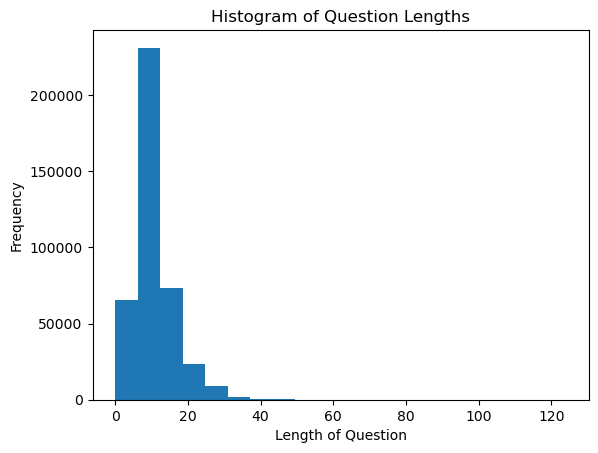

In [52]:
import matplotlib.pyplot as plt

# Create a list to store the lengths of the internal lists
lengths = [len(internal_list) for internal_list in question1_tokens]

# Create a histogram
plt.hist(lengths, bins=20)  # Adjust the number of bins as needed
plt.xlabel('Length of Question')
plt.ylabel('Frequency')
plt.title('Histogram of Question Lengths')

# Show the histogram
plt.show()

In [53]:
# Tokenization and sequence padding
max_seq_length = 40  # Define your maximum sequence length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(question1_tokens + question2_tokens)

question1_sequences = tokenizer.texts_to_sequences(question1_tokens)
question2_sequences = tokenizer.texts_to_sequences(question2_tokens)
question1_sequences = pad_sequences(question1_sequences, maxlen=max_seq_length)
question2_sequences = pad_sequences(question2_sequences, maxlen=max_seq_length)


In [54]:
# Split data into training and testing sets
X = np.column_stack((question1_sequences, question2_sequences))
y = df_train['is_duplicate'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Build the LSTM model
embedding_dim = 100  
lstm_units = 64

input1 = Input(shape=(max_seq_length,))
input2 = Input(shape=(max_seq_length,))

embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim)
lstm_layer = LSTM(lstm_units)

encoded1 = lstm_layer(embedding_layer(input1))
encoded2 = lstm_layer(embedding_layer(input2))

2023-10-06 16:59:37.320553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-06 16:59:37.321000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-06 16:59:37.321561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [56]:
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape)

(90210, 100)


In [57]:
# Concatenate 
merged = Concatenate()([encoded1, encoded2])

# Add one or more Dense layers
dense_units = 128  # Define the number of units in the dense layers

dense1 = Dense(dense_units, activation='relu', kernel_initializer=HeNormal())(merged)  # Add a dense layer after the Concatenate layer
dense2 = Dense(dense_units, activation='relu', kernel_initializer=HeNormal())(dense1)  # Optionally, you can add more dense layers

# Add the final output layer
output = Dense(1, activation='sigmoid')(dense2)

model_lstm = Model(inputs=[input1, input2], outputs=output)

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [58]:
model_lstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 40, 100)      9021000     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 64)           42240       ['embedding_1[0][0]',      

In [59]:
from keras.utils.vis_utils import plot_model

plot_model(model_lstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [73]:

# Train the model
model_lstm.fit([X_train[:, :max_seq_length], X_train[:, max_seq_length:]], y_train, batch_size=64, epochs=5, validation_data=([X_test[:, :max_seq_length], X_test[:, max_seq_length:]], y_test))

Epoch 1/5


2023-10-06 17:27:39.847309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-06 17:27:39.848665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-06 17:27:39.849356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5054/5054 [==============================] - ETA: 0s - loss: 0.4657 - accuracy: 0.7755

2023-10-06 17:31:31.139342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-06 17:31:31.140102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-06 17:31:31.140627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5054/5054 [==============================] - 239s 47ms/step - loss: 0.4657 - accuracy: 0.7755 - val_loss: 0.4103 - val_accuracy: 0.8103
Epoch 2/5
5054/5054 [==============================] - 551s 109ms/step - loss: 0.3403 - accuracy: 0.8484 - val_loss: 0.3897 - val_accuracy: 0.8245
Epoch 3/5
5054/5054 [==============================] - 234s 46ms/step - loss: 0.2631 - accuracy: 0.8874 - val_loss: 0.4116 - val_accuracy: 0.8307
Epoch 4/5
5054/5054 [==============================] - 236s 47ms/step - loss: 0.2047 - accuracy: 0.9145 - val_loss: 0.4219 - val_accuracy: 0.8315
Epoch 5/5
5054/5054 [==============================] - 240s 47ms/step - loss: 0.1605 - accuracy: 0.9344 - val_loss: 0.4768 - val_accuracy: 0.8281


In [74]:
from sklearn.metrics import classification_report

# Assuming you have a trained model 'model'
y_pred = model_lstm.predict([X_test[:, :max_seq_length], X_test[:, max_seq_length:]])

# Convert the predictions to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred_binary))

2023-10-06 17:55:04.389475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-06 17:55:04.390484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-06 17:55:04.391065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2527/2527 [==============================] - 10s 4ms/step
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     51026
           1       0.74      0.81      0.78     29832

    accuracy                           0.83     80858
   macro avg       0.81      0.82      0.82     80858
weighted avg       0.83      0.83      0.83     80858



### Using Transformer Architecture

In [61]:
from transformers import TrainingArguments, Trainer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

import torch

In [62]:
model_name = "distilbert-base-uncased"  
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
random_indices = random.sample(range(len(df_train)), 30000)
df_sampled = df_train.iloc[random_indices]

#Sample 24,000 data points for training
training_indices = random.sample(range(len(df_sampled)), 24000)
df_train_v2 = df_sampled.iloc[training_indices]

# Create an evaluation DataFrame with the remaining 6,000 data points
evaluation_indices = [i for i in range(len(df_sampled)) if i not in training_indices]
df_eval = df_sampled.iloc[evaluation_indices]

In [64]:
# Prepare sentence pairs and labels for training data
sentence_pairs_train = [(row['question1'], row['question2']) for _, row in df_train_v2.iterrows()]
labels_train = df_train_v2['is_duplicate'].tolist()

In [65]:
#Prepare sentence pairs and labels for validation
sentence_pairs_eval = [(row['question1'], row['question2']) for _, row in df_eval.iterrows()]
labels_eval = df_eval['is_duplicate'].tolist()

In [66]:
encodings_train = tokenizer(sentence_pairs_train, return_tensors="pt", padding=True, truncation=True)

encodings_eval = tokenizer(sentence_pairs_eval, return_tensors="pt", padding=True, truncation=True)

In [67]:
type(encodings_train)

embedding_dim = encodings_train['input_ids'].shape
print("Embedding Dimension:", embedding_dim)

Embedding Dimension: torch.Size([24000, 136])


In [68]:
class QuestionPairClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

dataset_train = QuestionPairClassificationDataset(encodings_train, labels_train)
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True)

dataset_eval = QuestionPairClassificationDataset(encodings_eval, labels_eval)
dataloader_eval = torch.utils.data.DataLoader(dataset_eval, batch_size=8, shuffle=True)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    report_to="tensorboard",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    save_steps=10_00,
    save_total_limit=2,
    evaluation_strategy="steps",
    eval_steps=5_00,
    remove_unused_columns=False,
    push_to_hub=False
)

training_args = TrainingArguments(
    output_dir="./results",
    report_to="tensorboard",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    save_steps=10_00,
    save_total_limit=2,
    evaluation_strategy="steps",
    eval_steps=5_00,
    remove_unused_columns=False,
    push_to_hub=False
)

In [70]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_eval,
)

In [32]:

trainer.train()

  0%|          | 0/3000 [00:00<?, ?it/s]

{'loss': 0.3525, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.17}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.8170190453529358, 'eval_runtime': 78.4087, 'eval_samples_per_second': 76.522, 'eval_steps_per_second': 9.565, 'epoch': 0.17}
{'loss': 0.4959, 'learning_rate': 3.3333333333333335e-05, 'epoch': 0.33}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.4624652862548828, 'eval_runtime': 105.2002, 'eval_samples_per_second': 57.034, 'eval_steps_per_second': 7.129, 'epoch': 0.33}
{'loss': 0.4449, 'learning_rate': 2.5e-05, 'epoch': 0.5}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.4418240487575531, 'eval_runtime': 66.7798, 'eval_samples_per_second': 89.848, 'eval_steps_per_second': 11.231, 'epoch': 0.5}
{'loss': 0.4366, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.67}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.42845773696899414, 'eval_runtime': 74.9901, 'eval_samples_per_second': 80.011, 'eval_steps_per_second': 10.001, 'epoch': 0.67}
{'loss': 0.4051, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.83}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.41169074177742004, 'eval_runtime': 75.7228, 'eval_samples_per_second': 79.236, 'eval_steps_per_second': 9.905, 'epoch': 0.83}
{'loss': 0.4112, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.4112699031829834, 'eval_runtime': 68.16, 'eval_samples_per_second': 88.028, 'eval_steps_per_second': 11.004, 'epoch': 1.0}
{'train_runtime': 4154.4514, 'train_samples_per_second': 5.777, 'train_steps_per_second': 0.722, 'train_loss': 0.4243719482421875, 'epoch': 1.0}


TrainOutput(global_step=3000, training_loss=0.4243719482421875, metrics={'train_runtime': 4154.4514, 'train_samples_per_second': 5.777, 'train_steps_per_second': 0.722, 'train_loss': 0.4243719482421875, 'epoch': 1.0})

In [71]:
results = trainer.evaluate()
print(results)

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.6814428567886353, 'eval_runtime': 178.6051, 'eval_samples_per_second': 33.594, 'eval_steps_per_second': 4.199}


In [80]:
# checkpoint_dir = "results/checkpoint-3000" 
# tokenizer_bert = DistilBertTokenizer.from_pretrained(checkpoint_dir)
# model_bert = DistilBertForSequenceClassification.from_pretrained(checkpoint_dir)

In [81]:
# predictions = []
# true_labels = []

# # Set the model to evaluation mode
# model.eval()

# for batch in dataloader_eval:
#     input_ids = batch['input_ids']
#     attention_mask = batch['attention_mask']
#     labels = batch['labels']

#     with torch.no_grad():
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)

#     logits = outputs.logits
#     batch_predictions = torch.argmax(logits, dim=1)

#     predictions.extend(batch_predictions.tolist())
#     true_labels.extend(labels.tolist())

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy = accuracy_score(true_labels, predictions)
# precision = precision_score(true_labels, predictions)
# recall = recall_score(true_labels, predictions)
# f1 = f1_score(true_labels, predictions)

# print(f"Test Accuracy: {accuracy * 100:.2f}%")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {f1:.2f}")
